#DATASCI W261: Machine Learning at Scale 

* **Sayantan Satpati**
* **sayantan.satpati@ischool.berkeley.edu**
* **W261**
* **Week-7**
* **Assignment-7**
* **Date of Submission: 27-OCT-2015**

#  === Week 7: Graph Processing ===

## HW 7.0: Toy Dataset
---

Shortest path graph distances (toy networks)===

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!


In [ ]:
!aws s3 cp s3://ucb-mids-mls-networks/undirected_toy.txt .
!aws s3 cp s3://ucb-mids-mls-networks/directed_toy.txt .

In [38]:
!echo "UnDirected\n"
!head undirected_toy.txt
!echo "\nDirected\n"
!head directed_toy.txt

UnDirected

1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Directed

1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}


## First Version: Distributed Shortest Path Algorithm using Map/Reduce
___

In [51]:
%%writefile mrjob_sp_hw70.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
import sys
import ast

'''
Record Emitted by Mapper/Reducer:
Node <TAB> NULL|Neighbor Dict,Distance,Parent/Child,V|Q|U
'''

class ShortestPath(MRJob):
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   reducer=self.reducer)
        ]
    
    def val1(self,ngbr,dist,parent,child,state):
        return '{0}|{1}|{2}/{3}|{4}'.format(ngbr,str(dist),parent,child,state)
    
    def val2(self,ngbr,dist,path,state):
        return '{0}|{1}|{2}|{3}'.format(ngbr,str(dist),path,state)
    
    def mapper_init(self):
        self.frontier_node = get_jobconf_value('frontier_node')
        if not self.frontier_node:
            # Save a list of visited nodes
            self.visited = [s.strip() for s in 
                              open('visited.txt').readlines()]
            open('visited.txt', 'w').close()
            #sys.stderr.write('### Visited: {0}\n'.format(self.visited))
        #sys.stderr.write('### Frontier Node: {0}\n'.format(self.frontier_node))

    def mapper(self, _, line):
        line = line.replace("\"","")
        # Passed only to first iteration
        t = line.strip().split('\t')
        node = t[0]
        #sys.stderr.write('[M] {0}\n'.format(line))
        if self.frontier_node: # First frontier
            neighbors = ast.literal_eval(t[1])    
            if node == self.frontier_node:
                # Mark Node as Visited
                yield node, self.val1(neighbors,0,node,node,'V')
                self.increment_counter('graph', 'nodes', amount=1)
                
                # Open/Emit Frontiers
                for k,v in neighbors.iteritems():
                    self.increment_counter('graph', 'frontiers', amount=1)
                    self.increment_counter('graph', 'links', amount=1)
                    yield k, self.val1('NULL',v,node,k,'Q')
            else:
                # Rest Passthrough
                yield node, self.val1(neighbors,sys.maxint,'NULL','NULL','U')
        else: # Not First
            t1 = t[1].split("|")
            neighbors = {}
            if t1[0] != 'NULL':
                neighbors = ast.literal_eval(t1[0])
            dist = t1[1]
            path = t1[2]
            status = t1[3]
            if status == 'Q':
                # Mark Node as Visited
                yield node, self.val2(neighbors,dist,path,'V')
                self.increment_counter('graph', 'nodes', amount=1)
                self.visited.append(node)
                
                # Open/Emit Frontiers if NOT Visited
                for k,v in neighbors.iteritems():
                    if k not in self.visited:
                        self.increment_counter('graph', 'frontiers', amount=1)
                        self.increment_counter('graph', 'links', amount=1)
                        yield k, self.val1('NULL', int(dist) + int(v), path, k,'Q')
            else:
                yield t[0], t[1] # Passthrough (Rest)
            
    def combiner(self, key, counts):
        pass

    def reducer(self, key, values):
        '''
        Passed to Reducer would be either of these combinations:
        1. Visited and Frontiers (Merge based on distance)
        2. Frontiers and Unvisited (Merge)
        3. Unvisited
        '''
        vList = [value for value in values]
        # Set min distance to integer max
        min_dist = sys.maxint
        
        if len(vList) == 1:
            yield key, vList[0]
        else:
            neighbors = None
            dist = None
            path = None
            status = None
            
            for value in vList:
                #sys.stderr.write('[R1] {0} : {1}\n'.format(key,value))
                t = value.split("|")
                #sys.stderr.write('[R2] D:{0},MD:{1}\n'.format(dist,min_dist))

                if int(t[1]) < min_dist:
                    dist = t[1]
                    path = t[2]
                    status = t[3]
                    min_dist = int(t[1])
                    
                if t[3] == 'V' or t[3] == 'U':
                    neighbors = ast.literal_eval(t[0])
                    
                #sys.stderr.write('[R3] {0}\n'.format(self.val2(neighbors,dist,path,status)))
                
            #sys.stderr.write('[R4] {0} # {1} \n\n'.format(key, self.val2(neighbors,dist,path,status)))
            yield key, self.val2(neighbors,dist,path,status)    
            
    
if __name__ == '__main__':
    ShortestPath.run()

Overwriting mrjob_sp_hw70.py


In [52]:
!chmod a+x mrjob_sp_hw70.py

In [54]:
%reload_ext autoreload
%autoreload 2
from mrjob_sp_hw70 import ShortestPath

files = ['undirected_toy.txt', 'directed_toy.txt']

for input_file in files:
    print '\n@@@@@ SHORTEST PATH ANALYSIS FOR: {0}\n'.format(input_file)
    
    # Init
    frontiers = 1
    nodes = 0
    links = 0
    cnt = 0
    
    while frontiers and frontiers > 0:
        print "iteration: " + str(cnt+1) + ":"

        mr_job = None
        if cnt == 0: # First Iteration
            mr_job = ShortestPath(args=[input_file,
                                '--jobconf', 'frontier_node=1',
                                '--no-strict-protocol'])
        else:
            mr_job = ShortestPath(args=[input_file + '1',
                                '--file', 'visited.txt',
                                '--no-strict-protocol'])

        with mr_job.make_runner() as runner: 
            runner.run()
            # stream_output: get access of the output 
            with open(input_file + '1','w') as f, open('visited.txt','w') as f1:
                for line in runner.stream_output():
                    parsed_line = mr_job.parse_output_line(line)
                    print parsed_line
                    if parsed_line[1].endswith('V'):
                        f1.write(parsed_line[0] + '\n')
                    f.write(line)

            if 'graph' in runner.counters()[0]:
                print "# Counters: {0}".format(runner.counters())
                frontiers = runner.counters()[0]['graph'].get('frontiers', 0)
                nodes += runner.counters()[0]['graph'].get('nodes', 0)
                links += runner.counters()[0]['graph'].get('links', 0)
            else:
                break;

        cnt += 1
    
    print "# Nodes: {0}".format(nodes) 
    print "# Links: {0}".format(links) 


@@@@@ SHORTEST PATH ANALYSIS FOR: undirected_toy.txt

iteration: 1:
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|Q")
('3', "{'2': 1, '4': 1}|9223372036854775807|NULL/NULL|U")
('4', "{'3': 1, '2': 1, '5': 1}|9223372036854775807|NULL/NULL|U")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|Q")
# Counters: [{'graph': {'nodes': 1, 'links': 2, 'frontiers': 2}}]
iteration: 2:
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|V")
('3', "{'2': 1, '4': 1}|2|1/2/3|Q")
('4', "{'3': 1, '2': 1, '5': 1}|2|1/2/4|Q")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|V")
# Counters: [{'graph': {'nodes': 2, 'links': 4, 'frontiers': 4}}]
iteration: 3:
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|V")
('3', "{'2': 1, '4': 1}|2|1/2/3|V")
('4', "{'3': 1, '2': 1, '5': 1}|2|1/2/4|V")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|V")
# Counters: [{'graph': {'nodes': 2, 'links': 1, 'frontiers': 1}}]
iteration: 4:
('1', "{'2': 1, '5': 1}|0|1/1

## Undirected Graph

### Shortest Path: 1/2/4


***('4', "{'3': 1, '2': 1, '5': 1}|2|1/2/4|V")***


## Directed Graph

### Shortest Path: 1/2/4/5

***('5', "{'1': 1, '2': 1, '4': 1}|3|1/2/4/5|V")***

## HW 7.0: Main Dataset
---

==Main dataset 1: NLTK synonyms==

In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt
s3://ucb-mids-mls-networks/synNet/indices.txt

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

In [ ]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt .
!aws s3 cp s3://ucb-mids-mls-networks/synNet/indices.txt .

In [32]:
!echo "Graph\n"
!head -n 5 synNet.txt
!wc -l synNet.txt
!echo "\nIndices\n"
!head -n 5 indices.txt
!wc -l indices.txt

Graph

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
    8271 synNet.txt

Indices

A	1
As	2
a	3
as	4
AB	5
    8271 indices.txt


## HW 7.1
---

Exploratory data analysis (NLTK synonyms)===

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [60]:
%%writefile mrjob_sp_hw71.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
import sys
import ast

class Graph_EDA(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                  reducer_init=self.reducer_init,
                  reducer=self.reducer,
                 reducer_final=self.reducer_final,
                  jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1n',
                            }
                   )
        ]
    

    def mapper(self, _, line):
        line = line.replace("\"","")
        # Passed only to first iteration
        t = line.strip().split('\t')
        node = t[0]
        neighbors = ast.literal_eval(t[1]) 
        self.increment_counter('graph', 'nodes', amount=1)
        self.increment_counter('graph', 'links', amount=len(neighbors))
        yield len(neighbors), node
            
    def combiner(self, key, values):
        l = [v for v in values]
        yield key,len(l)

    def reducer_init(self):
        self.max_link_bucket = 0
        self.max_link_num_nodes = 0
        self.min_link_bucket = 0
        self.min_link_num_nodes = sys.maxint
        
    def reducer(self, key, values):
        n_nodes = sum(values)
        
        if n_nodes > self.max_link_num_nodes:
            self.max_link_bucket = key
            self.max_link_num_nodes = n_nodes
            
        if n_nodes < self.min_link_num_nodes:
            self.min_link_bucket = key
            self.min_link_num_nodes = n_nodes
        
        self.increment_counter('graph', 'link_buckets', amount=1)
        yield key,n_nodes
        
    def reducer_final(self):
        c_min = '[MIN_NUM_NODES]{0}'.format(self.min_link_bucket)
        self.increment_counter('graph', c_min, amount=self.min_link_num_nodes)
        c_max = '[MAX_NUM_NODES]{0}'.format(self.max_link_bucket)
        self.increment_counter('graph', c_max, amount=self.max_link_num_nodes)
            
    
if __name__ == '__main__':
    Graph_EDA.run()

Overwriting mrjob_sp_hw71.py


In [61]:
!chmod a+x mrjob_sp_hw71.py

In [62]:
%reload_ext autoreload
%autoreload 2
from mrjob_sp_hw71 import Graph_EDA
import pprint

input_file = 'synNet.txt'

mr_job = Graph_EDA(args=[input_file,
                        '--no-strict-protocol'])

with mr_job.make_runner() as runner: 
    runner.run()
    
    with open(input_file + '2','w') as f:
        for line in runner.stream_output():
            #parsed_line = mr_job.parse_output_line(line)
            #print parsed_line
            f.write(line)

    print "# MR Counters:"
    pprint.pprint(runner.counters()[0])
    
!wc -l synNet.txt2

# MR Counters:
{'graph': {'[MAX_NUM_NODES]1': 1421,
           '[MIN_NUM_NODES]117': 1,
           'link_buckets': 83,
           'links': 61134,
           'nodes': 8271}}
      83 synNet.txt2


In [15]:
# Looks like Power Law (Graphed Later)
!cat synNet.txt2 | sort -n -k1 | head -n 10

1	1421
2	1127
3	906
4	783
5	637
6	488
7	429
8	309
9	296
10	254


In [2]:
%reload_ext autoreload
%autoreload 2
from mrjob_sp_hw70 import ShortestPath

input_file = 'synNet.txt'

# Init
frontiers = 1
nodes = 0
links = 0
cnt = 0

while frontiers and frontiers > 0:
    print "iteration: " + str(cnt+1) + ":"

    mr_job = None
    if cnt == 0: # First Iteration
        mr_job = ShortestPath(args=[input_file,
                            '--jobconf', 'frontier_node=1',
                            '--no-strict-protocol'])
    else:
        mr_job = ShortestPath(args=[input_file + '1',
                            '--file', 'visited.txt',
                            '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        with open(input_file + '1','w') as f, open('visited.txt','w') as f1:
            for line in runner.stream_output():
                parsed_line = mr_job.parse_output_line(line)
                #print parsed_line
                if parsed_line[1].endswith('V'):
                    f1.write(parsed_line[0] + '\n')
                f.write(line)

        if 'graph' in runner.counters()[0]:
            print "# Counters: {0}".format(runner.counters())
            frontiers = runner.counters()[0]['graph'].get('frontiers', 0)
            nodes += runner.counters()[0]['graph'].get('nodes', 0)
            links += runner.counters()[0]['graph'].get('links', 0)
        else:
            break;

    cnt += 1

print "# Nodes: {0}".format(nodes) 
print "# Links: {0}".format(links)

     

iteration: 1:
# Counters: [{'graph': {'nodes': 1, 'links': 3, 'frontiers': 3}}]
iteration: 2:
# Counters: [{'graph': {'nodes': 3, 'links': 6, 'frontiers': 6}}]
iteration: 3:
# Counters: [{'graph': {'nodes': 2, 'links': 13, 'frontiers': 13}}]
iteration: 4:
# Counters: [{'graph': {'nodes': 13, 'links': 170, 'frontiers': 170}}]
iteration: 5:
# Counters: [{'graph': {'nodes': 94, 'links': 985, 'frontiers': 985}}]
iteration: 6:
# Counters: [{'graph': {'nodes': 460, 'links': 4778, 'frontiers': 4778}}]
iteration: 7:
# Counters: [{'graph': {'nodes': 1601, 'links': 13329, 'frontiers': 13329}}]
iteration: 8:
# Counters: [{'graph': {'nodes': 2470, 'links': 7591, 'frontiers': 7591}}]
iteration: 9:
# Counters: [{'graph': {'nodes': 1298, 'links': 1721, 'frontiers': 1721}}]
iteration: 10:
# Counters: [{'graph': {'nodes': 422, 'links': 413, 'frontiers': 413}}]
iteration: 11:
# Counters: [{'graph': {'nodes': 159, 'links': 100, 'frontiers': 100}}]
iteration: 12:
# Counters: [{'graph': {'nodes': 20, 'link

## Results of EDA
---

* Total Number of Nodes: **8271**

* Total Number of Links: **61134**

* Max num of Nodes containing same num of Links (1): **1421 nodes have 1 Links.**

* Min num of Nodes containing same num of Links (117): **1 node has 117 Links.** This is a tie. A lot of nodes have only 1 Link.

* Total Number of Unique Links: $61134 / 2$ == **30567**

* Number of Nodes reachable from Node "1": **6546**

* Number of Links reachable from Node "1": **29117**

```
# MR Counters:
{'graph': {'[MAX_NUM_NODES]1': 1421,
           '[MIN_NUM_NODES]117': 1,
           'link_buckets': 83,
           'links': 61134,
           'nodes': 8271}}
```

## Long Tail Distribution showing evidence of Power Law
___

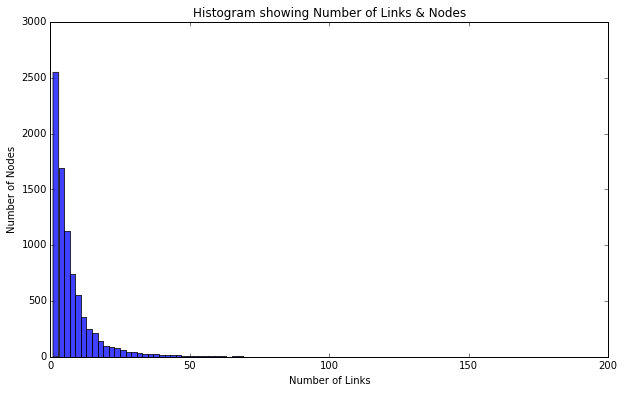

In [10]:
import ast, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def hist_link_node(files, bins=None):
    degrees = []
    for file in files:
        with open(file, 'r') as f:
            for l in f:
                t = l.split('\t')
                n_links = int(t[0])
                n_nodes = int(t[1]) 

                for i in xrange(n_nodes):
                    degrees.append(n_links)

    plt.figure(figsize=(10,6))
    plt.title('Histogram showing Number of Links & Nodes')
    plt.xlabel('Number of Links')
    plt.ylabel('Number of Nodes')
    if not bins:
        bins = range(min(degrees), max(degrees) + 2, 2)
    plt.hist(degrees, bins=bins, facecolor='blue', alpha=0.75)
    
hist_link_node(['synNet.txt2'])

## HW 7.3
___

```
==Main dataset 2: English Wikipedia==

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.
```

In [5]:
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt .
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt .
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt .

download: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt to ./all-pages-indexed-out.txt
download: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt to ./all-pages-indexed-in.txt
download: s3://ucb-mids-mls-networks/wikipedia/indices.txt to ./indices.txt


In [6]:
!head -n 3 all-pages-indexed-out.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}


In [7]:
!head -n 3 all-pages-indexed-in.txt

90	{'8430954': 2}
212	{'3351482': 1, '3635586': 1}
332	{'8996949': 1}


In [8]:
!head -n 3 indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17


## HW  7.3
___

=== Exploratory data analysis (Wikipedia)===

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

In [7]:
!aws s3 rm --recursive s3://w261/hw73/output/
!python mrjob_sp_hw71.py -r emr \
 s3://w261/all-pages-indexed-out.txt \
 --output-dir=s3://w261/hw73/output/ \
 --no-output \
 --no-strict-protocol

using configs in /Users/ssatpati/.mrjob.conf
using existing scratch bucket mrjob-5249db1e872328e3
using s3://mrjob-5249db1e872328e3/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_sp_hw71.ssatpati.20151025.234505.465338
writing master bootstrap script to /var/folders/h5/1q71m1c54cn07f16c232pqgm38ynd8/T/mrjob_sp_hw71.ssatpati.20151025.234505.465338/b.py
Copying non-input files into s3://mrjob-5249db1e872328e3/tmp/mrjob_sp_hw71.ssatpati.20151025.234505.465338/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-L30PGUBQBZLY
Created new job flow j-L30PGUBQBZLY
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.2s ago, sta

In [71]:
!aws s3 ls s3://w261/hw73/output/
!aws --recursive s3 cp s3://w261/hw73/output .

2015-10-25 16:09:03          0 _SUCCESS
2015-10-25 16:08:47       1851 part-00000
2015-10-25 16:08:46       1925 part-00001
2015-10-25 16:08:50       1724 part-00002
2015-10-25 16:09:01       1852 part-00003
2015-10-25 16:08:47       1817 part-00004
2015-10-25 16:09:00       1805 part-00005
2015-10-25 16:09:08       1896 part-00006
2015-10-25 16:09:10       1885 part-00007
download: s3://w261/hw73/output/_SUCCESS to ./_SUCCESS
download: s3://w261/hw73/output/part-00004 to ./part-00004
download: s3://w261/hw73/output/part-00002 to ./part-00002
download: s3://w261/hw73/output/part-00006 to ./part-00006
download: s3://w261/hw73/output/part-00000 to ./part-00000
download: s3://w261/hw73/output/part-00003 to ./part-00003
download: s3://w261/hw73/output/part-00005 to ./part-00005
download: s3://w261/hw73/output/part-00007 to ./part-00007
download: s3://w261/hw73/output/part-00001 to ./part-00001


['./part-00000', './part-00001', './part-00002', './part-00003', './part-00004', './part-00005', './part-00006', './part-00007']


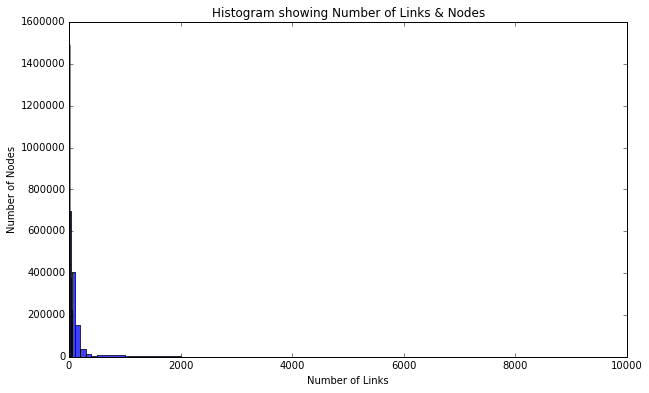

In [12]:
import glob
files = [f for f in glob.glob('./part-*')]
print files
hist_link_node(files, bins=[10,20,30,40,50,100,200,300,400,500,1000,2000,10000])

## HW  7.4
___

===Shortest path graph distances (Wikipedia)===

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

## [Alternate Approach] Distributed Shortest Path Algorithm using Map/Reduce 

***Finds Shortest Path between Start & Stop Nodes. Stops whenever Stop Node is found the first time***

***Relies on Job Counters for exchaning information between MRJob and Driver (No file transfer involved)***


In [1]:
%%writefile mrjob_sp_hw74.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
import sys
import ast

'''
Record Emitted by Mapper/Reducer:
Node <TAB> NULL|Neighbor Dict,Distance,Parent/Child,V|Q|U
'''

class ShortestPath_AWS(MRJob):
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   reducer=self.reducer)
        ]
    
    def val1(self,ngbr,dist,parent,child,state):
        return '{0}|{1}|{2}/{3}|{4}'.format(ngbr,str(dist),parent,child,state)
    
    def val2(self,ngbr,dist,path,state):
        return '{0}|{1}|{2}|{3}'.format(ngbr,str(dist),path,state)
    
    def mapper_init(self):
        self.start_node = get_jobconf_value('start_node')
        self.stop_node = get_jobconf_value('stop_node')
        sys.stderr.write('### Start/Frontier Node: {0}\n'.format(self.start_node))
        sys.stderr.write('### Stop: {0}\n'.format(self.stop_node))

    def mapper(self, _, line):
        line = line.replace("\"","")
        # Passed only to first iteration
        t = line.strip().split('\t')
        node = t[0]
        #sys.stderr.write('[M] {0}\n'.format(line))
        if self.start_node: # First frontier
            neighbors = ast.literal_eval(t[1])    
            if node == self.start_node:
                # Mark Node as Visited
                yield node, self.val1(neighbors,0,node,node,'V')
                self.increment_counter('graph', 'nodes', amount=1)
                
                # Open/Emit Frontiers
                for k,v in neighbors.iteritems():
                    self.increment_counter('graph', 'frontiers', amount=1)
                    yield k, self.val1('NULL',v,node,k,'Q')
            else:
                # Rest Passthrough
                yield node, self.val1(neighbors,sys.maxint,'NULL','NULL','U')
        else: # Not First
            t1 = t[1].split("|")
            neighbors = {}
            if t1[0] != 'NULL':
                neighbors = ast.literal_eval(t1[0])
            dist = t1[1]
            path = t1[2]
            status = t1[3]
            if status == 'Q':
                # Mark Node as Visited
                yield node, self.val2(neighbors,dist,path,'V')
                self.increment_counter('graph', 'nodes', amount=1)
                
                # Signal Driver to Stop Processing anymore
                if node == self.stop_node:
                    self.increment_counter('graph', 'action_stop', amount=1)
                
                if neighbors and len(neighbors) > 0:
                    # Open/Emit Frontiers if NOT Visited
                    for k,v in neighbors.iteritems():
                        self.increment_counter('graph', 'frontiers', amount=1)
                        yield k, self.val1('NULL', int(dist) + int(v), path, k,'Q')
            else:
                yield t[0], t[1] # Passthrough (Rest)
            
    def combiner(self, key, counts):
        pass

    def reducer(self, key, values):
        '''
        Passed to Reducer would be either of these combinations:
        1. Visited and Frontiers (Merge based on distance)
        2. Frontiers and Unvisited (Merge)
        3. Unvisited
        '''
        vList = [value for value in values]
        # Set min distance to integer max
        min_dist = sys.maxint
        
        if len(vList) == 1:
            yield key, vList[0]
        else:
            neighbors = None
            dist = None
            path = None
            status = None
            
            for value in vList:
                #sys.stderr.write('[R1] {0} : {1}\n'.format(key,value))
                t = value.split("|")
                #sys.stderr.write('[R2] D:{0},MD:{1}\n'.format(dist,min_dist))

                if int(t[1]) < min_dist:
                    dist = t[1]
                    path = t[2]
                    status = t[3]
                    min_dist = int(t[1])
                    
                if t[3] == 'V' or t[3] == 'U':
                    neighbors = ast.literal_eval(t[0])
                    
                #sys.stderr.write('[R3] {0}\n'.format(self.val2(neighbors,dist,path,status)))
                
            #sys.stderr.write('[R4] {0} # {1} \n\n'.format(key, self.val2(neighbors,dist,path,status)))
            yield key, self.val2(neighbors,dist,path,status)    
            
    
if __name__ == '__main__':
    ShortestPath_AWS.run()

Overwriting mrjob_sp_hw74.py


In [2]:
!chmod a+x mrjob_sp_hw74.py

### Test on AWS: Using the Directed Toy Dataset

In [11]:
%reload_ext autoreload
%autoreload 2
from mrjob_sp_hw74 import ShortestPath_AWS
import pprint
import time

# Delete Existing Output
!aws s3 rm --recursive s3://w261/hw74/output/
    
# Init
cnt = 0
start_node = 1
stop_node = 4

while True:
    print "iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://w261/hw74/output/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)

    mr_job = None
    if cnt == 0: # First Iteration
        mr_job = ShortestPath_AWS(args=['-r', 'emr', 's3://w261/undirected_toy.txt',
                            '--jobconf', 'start_node={0}'.format(start_node),
                            '--output-dir', out_dir,
                            '--no-strict-protocol',
                            '--pool-emr-job-flows', 
                            '--max-hours-idle', '1',
                            '--pool-name', 'ShortestDistance'])
    else: # Subsequent Iterations
        mr_job = ShortestPath_AWS(args=['-r', 'emr', 's3://w261/hw74/output/{0}/'.format(cnt-1),
                            '--jobconf', 'stop_node={0}'.format(stop_node),
                            '--output-dir', out_dir,
                            '--no-strict-protocol',
                            '--pool-emr-job-flows',
                            '--max-hours-idle', '1',
                            '--pool-name', 'ShortestDistance'])
        
    cnt += 1

    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)
        
        jf = runner.get_emr_job_flow_id()
        print "Job Flow Id: {0}".format(jf)
        
        time.sleep(10)
        
        # Get the Job Counters (MRJOB Bug: Programmatic Way Doesn't Work)
        !rm -f $jf
        !python -m mrjob.tools.emr.fetch_logs --counters $jf > $jf 2>&1
        
        
        frontiers = []
        action_stop = []

        graph = []
        marker = False
        d = {}
        with open(jf) as f:
            for l in f:
                l = l.strip()

                if l.startswith('Counters from step'):
                    marker = False
                    if len(d) > 0:
                        graph.append(d.copy())
                    d.clear()
                if l.startswith('graph'):
                    marker = True
                    continue

                if marker:
                    t = l.split(':')
                    d[t[0].strip()] = t[1].strip()


        pprint.pprint(graph)
        
        if len(graph) == 0:
            break
            
        if graph[-1].get('action_stop', '0') == '1':
            print("\n@@@@@ Shortest Path Found between Nodes: {0} and {1}, Aborting!!!".format(start_node, stop_node))
            !rm -rf ./distance;mkdir distance;
            !aws s3 cp --recursive $out_dir distance
            !grep -r \"$stop_node\" distance
            break
            
        if graph[-1].get('frontiers', 0) == 0:
            print('\n@@@@@ No more frontiers to explore, Aborting!!!')
            break
    
    


delete: s3://w261/hw74/output/0/part-00000
delete: s3://w261/hw74/output/0/_SUCCESS         


iteration: 1:
Output Dir: s3://w261/hw74/output/0
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|Q")
('3', "{'2': 1, '4': 1}|9223372036854775807|NULL/NULL|U")
('4', "{'3': 1, '2': 1, '5': 1}|9223372036854775807|NULL/NULL|U")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|Q")
Job Flow Id: j-5L8FHDPTKLNV
[{'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '7', 'links': '7', 'nodes': '2'},
 {'action_stop': '1', 'frontiers': '5', 'links': '5', 'nodes': '2'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'}]
iteration: 2:


Output Dir: s3://w261/hw74/output/1
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|V")
('3', "{'2': 1, '4': 1}|2|1/2/3|Q")
('4', "{'3': 1, '2': 1, '5': 1}|2|1/2/4|Q")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|V")
Job Flow Id: j-5L8FHDPTKLNV
[{'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '7', 'links': '7', 'nodes': '2'},
 {'action_stop': '1', 'frontiers': '5', 'links': '5', 'nodes': '2'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '7', 'links': '7', 'nodes': '2'}]
iteration: 3:


Output Dir: s3://w261/hw74/output/2
('1', "{'2': 1, '5': 1}|0|1/1|V")
('2', "{'1': 1, '3': 1, '5': 1, '4': 1}|1|1/2|V")
('3', "{'2': 1, '4': 1}|2|1/2/3|V")
('4', "{'3': 1, '2': 1, '5': 1}|2|1/2/4|V")
('5', "{'1': 1, '2': 1, '4': 1}|1|1/5|V")
Job Flow Id: j-5L8FHDPTKLNV
[{'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '7', 'links': '7', 'nodes': '2'},
 {'action_stop': '1', 'frontiers': '5', 'links': '5', 'nodes': '2'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '2', 'links': '2', 'nodes': '1'},
 {'frontiers': '7', 'links': '7', 'nodes': '2'},
 {'action_stop': '1', 'frontiers': '5', 'links': '5', 'nodes': '2'}]

@@@@@ Shortest Path Found between Nodes: 1 and 4, Aborting!!!
download: s3://w261/hw74/output/2/_SUCCESS to distance/_SUCCESS
download: s3://w261/hw74/output/2/part-00000 to distance/part-00000
distance/part-00000:"4"	"{'3': 1, '2': 1, '5': 1}|2|1/2/4|V"


### =========== Running on AWS on the Wikipedia Dataset =========== 

* MRJob has a bug: runner.counters() doesn't work for job flows that are re-used; it kept getting the counters from 1st run. To mitigate this error,  ***python -m mrjob.tools.emr.fetch_logs --counters ${JOB_FLOW_ID}*** has been used. This brings back all the counters, so some extra bit of processing is required to find the last one.

In [4]:
%reload_ext autoreload
%autoreload 2
from mrjob_sp_hw74 import ShortestPath_AWS
import pprint
import time

# Delete Existing Output
!aws s3 rm --recursive s3://w261/hw74/output/
    
# Init
cnt = 0
start_node = 6176135
stop_node = 13466359

while True:
    print "iteration: " + str(cnt+1) + ":"
    
    out_dir = 's3://w261/hw74/output/{0}'.format(cnt)
    print 'Output Dir: {0}'.format(out_dir)

    mr_job = None
    if cnt == 0: # First Iteration
        mr_job = ShortestPath_AWS(args=['-r', 'emr', 's3://w261/all-pages-indexed-out.txt',
                            '--jobconf', 'start_node={0}'.format(start_node),
                            '--output-dir', out_dir,
                            '--no-strict-protocol',
                            '--pool-emr-job-flows', 
                            '--max-hours-idle', '1',
                            '--pool-name', 'ShortestDistance',
                            '--bootstrap-action=s3://elasticmapreduce/bootstrap-actions/configure-hadoop -m mapred.tasktracker.map.tasks.maximum=4 -m mapreduce.map.memory.mb=3000'])
    else: # Subsequent Iterations
        mr_job = ShortestPath_AWS(args=['-r', 'emr', 's3://w261/hw74/output/{0}/'.format(cnt-1),
                            '--jobconf', 'stop_node={0}'.format(stop_node),
                            '--output-dir', out_dir,
                            '--no-strict-protocol',
                            '--pool-emr-job-flows',
                            '--max-hours-idle', '1',
                            '--pool-name', 'ShortestDistance',
                            '--bootstrap-action=s3://elasticmapreduce/bootstrap-actions/configure-hadoop -m mapred.tasktracker.map.tasks.maximum=4 -m mapreduce.map.memory.mb=3000'])
        
    cnt += 1

    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output
        '''
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)
        '''
        
        jf = runner.get_emr_job_flow_id()
        print "Job Flow Id: {0}".format(jf)
        
        time.sleep(30)
        
        # Get the Job Counters (MRJOB Bug: Programmatic Way Doesn't Work)
        !rm -f $jf
        !python -m mrjob.tools.emr.fetch_logs --counters $jf > $jf 2>&1
        
        
        frontiers = []
        action_stop = []

        graph = []
        marker = False
        d = {}
        with open(jf) as f:
            for l in f:
                l = l.strip()

                if l.startswith('Counters from step'):
                    marker = False
                    if len(d) > 0:
                        graph.append(d.copy())
                    d.clear()
                if l.startswith('graph'):
                    marker = True
                    continue

                if marker:
                    t = l.split(':')
                    d[t[0].strip()] = t[1].strip()


        pprint.pprint(graph)
        
        if len(graph) == 0:
            break
            
        if graph[-1].get('action_stop', '0') == '1':
            print("\n@@@@@ Shortest Path Found between Nodes: {0} and {1}, Aborting!!!".format(start_node, stop_node))
            !rm -rf ./distance;mkdir distance;
            !aws s3 cp --recursive $out_dir distance
            !grep -r \"$stop_node\" distance
            break
            
        if graph[-1].get('frontiers', 0) == 0:
            print('\n@@@@@ No more frontiers to explore, Aborting!!!')
            break
    
    


delete: s3://w261/hw74/output/0/_SUCCESS
delete: s3://w261/hw74/output/0/part-00009    
delete: s3://w261/hw74/output/0/part-00010         
delete: s3://w261/hw74/output/0/part-00000         
delete: s3://w261/hw74/output/0/part-00005         
delete: s3://w261/hw74/output/0/part-00002         
delete: s3://w261/hw74/output/0/part-00006         
delete: s3://w261/hw74/output/0/part-00007         
delete: s3://w261/hw74/output/0/part-00001         
delete: s3://w261/hw74/output/0/part-00008         
delete: s3://w261/hw74/output/0/part-00004          
delete: s3://w261/hw74/output/0/part-00003          
delete: s3://w261/hw74/output/0/part-00012          
delete: s3://w261/hw74/output/0/part-00011          
delete: s3://w261/hw74/output/0/part-00014          
delete: s3://w261/hw74/output/0/part-00013          
delete: s3://w261/hw74/output/0/part-00015          
delete: s3://w261/hw74/output/0/part-00016          
delete: s3://w261/hw74/output/0/part-00017          
delete: s3://w261/h

iteration: 1:
Output Dir: s3://w261/hw74/output/0
Job Flow Id: j-30KGFUMIJKI0H
[{'frontiers': '925', 'nodes': '1'}]
iteration: 2:


Output Dir: s3://w261/hw74/output/1
Job Flow Id: j-30KGFUMIJKI0H
[{'frontiers': '925', 'nodes': '1'}, {'frontiers': '112757', 'nodes': '925'}]
iteration: 3:


Output Dir: s3://w261/hw74/output/2
Job Flow Id: j-30KGFUMIJKI0H
[{'frontiers': '925', 'nodes': '1'},
 {'frontiers': '112757', 'nodes': '925'},
 {'action_stop': '1', 'frontiers': '4408799', 'nodes': '66152'}]

@@@@@ Shortest Path Found between Nodes: 6176135 and 13466359, Aborting!!!
download: s3://w261/hw74/output/2/_SUCCESS to distance/_SUCCESS
download: s3://w261/hw74/output/2/part-00000 to distance/part-00000
download: s3://w261/hw74/output/2/part-00001 to distance/part-00001
download: s3://w261/hw74/output/2/part-00002 to distance/part-00002
download: s3://w261/hw74/output/2/part-00003 to distance/part-00003
download: s3://w261/hw74/output/2/part-00004 to distance/part-00004
download: s3://w261/hw74/output/2/part-00005 to distance/part-00005
download: s3://w261/hw74/output/2/part-00006 to distance/part-00006
download: s3://w261/hw74/output/2/part-00007 to distance/part-00007
download: s3://w261/hw74/output/2/part-00008 to distance/part-00008
download: s3://w261/hw74/output/2/part

In [10]:
i = {}
with open('indices.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        i[t[1].strip()] = t[0].strip()

print "[Path] {0} --> {1} --> {2} --> {3}".format(i["6176135"],i["12905382"],i["10195527"],i["13466359"])

[Path] Ireland --> The Washington Post --> Peter S. Goodman --> University of California, Berkeley


### Shortest Path Between 6176135 and 13466359: 

* Path: **6176135/12905382/10195527/13466359**

* Distance: **3**

* 3|6176135/12905382/10195527/13466359|Q